* Obective: sentiment analysis
* Dataset: IMDb movie reviews dataset

# Explore Data


In [26]:
import matplotlib.pyplot as plt
import os
import re
import random
import numpy as np
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.18.0


## Download the dataset


In [27]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(dataset, 'aclImdb')

## Load Data

In [28]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [29]:
data_path = 'aclImdb_v1'
(train_texts, train_labels), (raw_test_texts, raw_test_labels)  = load_imdb_sentiment_analysis_dataset(data_path)


In [30]:
val_texts, val_labels = raw_test_texts[:int(len(raw_test_texts)/2)], raw_test_labels[:int(len(raw_test_texts)/2)]
test_texts, test_labels = raw_test_texts[int(len(raw_test_texts)/2):], raw_test_labels[int(len(raw_test_texts)/2):]

## Check the Data

In [31]:
for text, label in zip(train_texts[:5], train_labels[:5]):
    print(label, text)

0 POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some 

## Collect Key Metrics

In [32]:
"""Module to explore data.

Contains functions to help study, visualize and understand datasets.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)

    # Returns
        int, total number of classes.

    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.

    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [33]:
# Number of samples: Total number of examples you have in the data.
print(len(train_texts))

25000


In [34]:
# Number of classes: Total number of topics or categories in the data.
print(get_num_classes(train_labels))

2


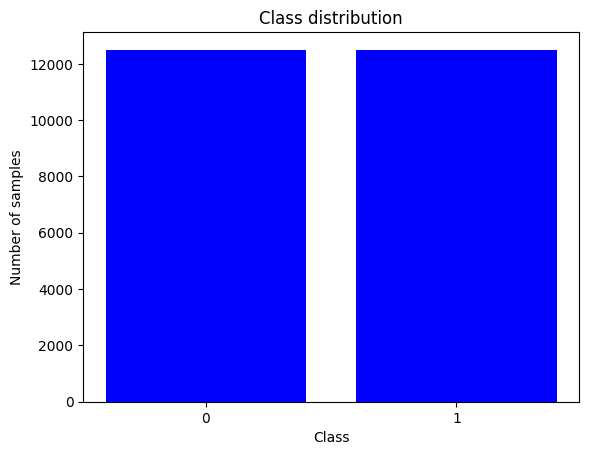

In [35]:
# Number of samples per class: Number of samples per class (topic/category).
plot_class_distribution(train_labels)

In [36]:
# Number of words per sample: Median number of words in one sample.
print(get_num_words_per_sample(train_texts))

174.0


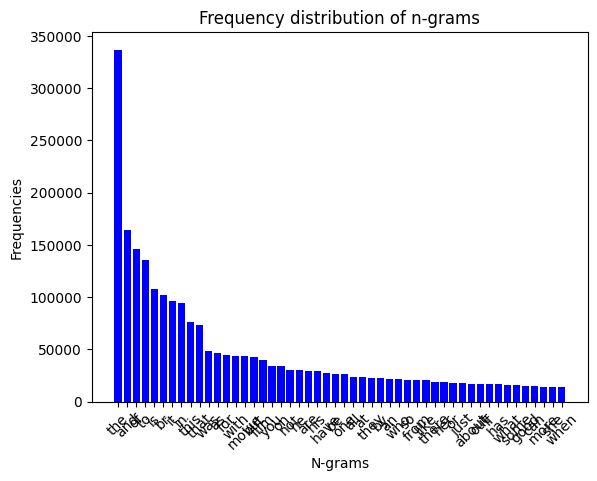

In [37]:
# Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
plot_frequency_distribution_of_ngrams(train_texts)

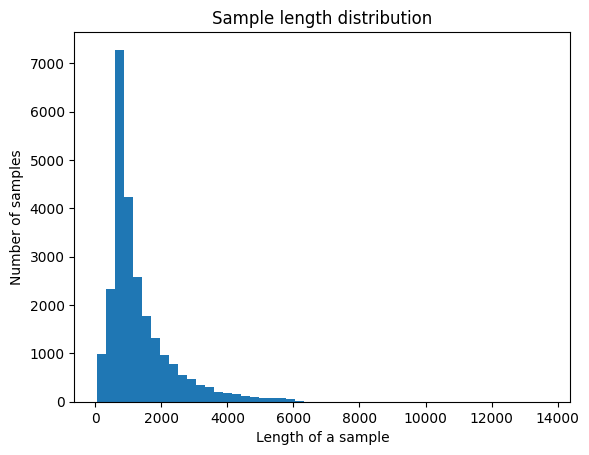

In [38]:
# Distribution of sample length: Distribution showing the number of words per sample in the dataset.
plot_sample_length_distribution(train_texts)

# Choose a Model

In [39]:
# Calculate the number of samples/number of words per sample ratio.
number_of_samples = len(train_texts)
number_of_words_per_sample = get_num_words_per_sample(train_texts)
ratio = number_of_samples / number_of_words_per_sample
print(ratio)

143.67816091954023


## Data Preprocessing

1. tokenization
2. vectorization
3. feature selection

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)


# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts, test_texts, top_k=1000):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')

    return x_train, x_val,x_test

In [41]:
x_train, x_val,x_test = ngram_vectorize(train_texts, train_labels, val_texts, test_texts)

# Build, Train, and Evaluate Your Model

In [42]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [43]:
# Build MLP model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_mlp(input_shape):
    model = Sequential([
        Dropout(0.2, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [44]:
model = build_mlp(x_train.shape[1:])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model

In [45]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train model
history = model.fit(x_train, train_labels, epochs=3, batch_size=32,
                     validation_data=(x_val, val_labels), callbacks=[early_stop], verbose=2)


Epoch 1/3
782/782 - 6s - 7ms/step - accuracy: 0.8335 - loss: 0.4210 - val_accuracy: 0.8519 - val_loss: 0.3586
Epoch 2/3
782/782 - 5s - 6ms/step - accuracy: 0.8773 - loss: 0.2945 - val_accuracy: 0.8844 - val_loss: 0.2901
Epoch 3/3
782/782 - 4s - 6ms/step - accuracy: 0.8818 - loss: 0.2805 - val_accuracy: 0.8854 - val_loss: 0.2813


## Evaluate the model

In [46]:
loss, accuracy = model.evaluate(x_test, np.array(test_labels), verbose=2)


print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 - 1s - 2ms/step - accuracy: 0.8928 - loss: 0.2509
Loss:  0.2509414851665497
Accuracy:  0.892799973487854


In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

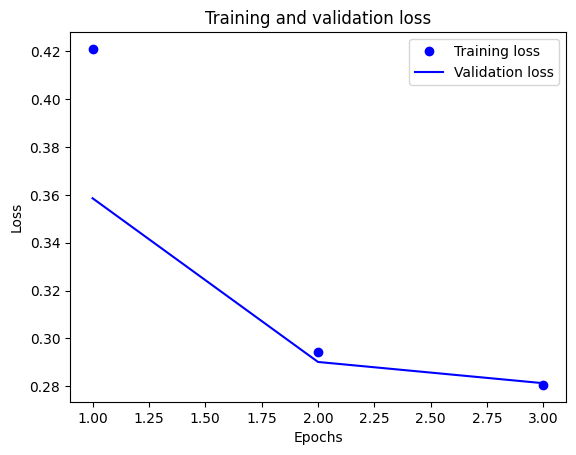

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

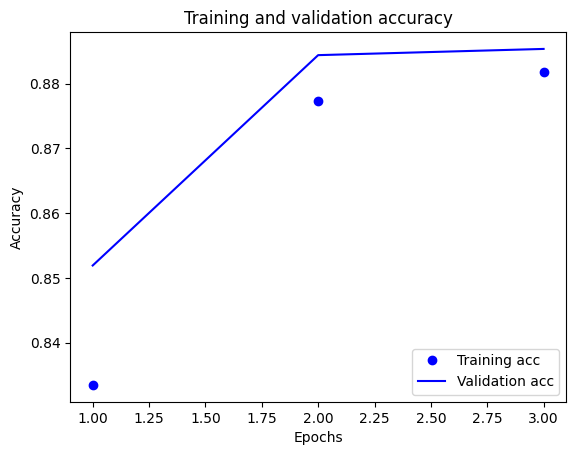

In [55]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()